<a href="https://colab.research.google.com/github/AdrianGuel/StochasticProcesses/blob/main/CubicgeodesicMPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsde
!pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 2.8 MB/s 
     |████████████████████████████████| 193 kB 8.2 MB/s 
     |████████████████████████████████| 38.1 MB 326 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 420 kB 4.2 MB/s 


In [ ]:
# Import methods
import torch
torch.cuda.empty_cache()
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
import torchsde
from scipy.integrate import odeint
import numpy as np
from KDEpy import FFTKDE
from scipy.signal import savgol_filter
from scipy import stats
from mpl_toolkits import mplot3d
import torch.nn.functional as F
from scipy.io import savemat

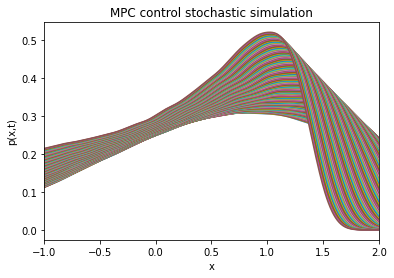

In [ ]:
#Parameters
mu0, gamma, Dx, beta0, t_size = 5/6, 1, (1/(2*0.3)), (1/(2*0.3)), 156
x_size=50**2
gpu = torch.device('cuda')
x = np.linspace(-10,10, x_size)
t = np.linspace(0, 0.1550, t_size)

#Stochastic simulation and kernel density estimation comparison SSvsLA changing gamma
class SDE(nn.Module):

    def __init__(self,gamma,D):
        super().__init__()
        self.thetaf = nn.Parameter(torch.tensor(gamma), requires_grad=False)  # Scalar parameter.
        self.thetag = nn.Parameter(torch.tensor(D), requires_grad=False)
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def f(self, t, y):
        return -self.thetaf*y**3+(-1.1937e5*t**8+1.0065e5*t**7-3.7512e4*t**6+8.0795e3*t**5-1.0930e3*t**4-40.5434*t**3+60.8695*t**2-36.2036*t-0.3967)
    
    def g(self,t,y):
        return self.thetag*0+ torch.sigmoid(y)*0-8.5259e6*t**8+3.4991e6*t**7-4.8740e5*t**6+1.2080e4*t**5+4.0420e3*t**4-540.4005*t**3+33.3364*t**2-12.6212*t+1.8742

batch_size, state_size = 10**6, 1
sde = SDE(gamma,np.sqrt(Dx))
ts = torch.linspace(0, 0.155, t_size) #0.1550
y0 = torch.normal(mu0, np.sqrt(beta0), size=(batch_size, state_size))

torch.cuda.empty_cache()
sde = SDE(gamma,np.sqrt(Dx)).to(gpu)
ts = ts.to(gpu)
y0 = y0.to(gpu)
pdf= torch.zeros([x_size, t_size])
pdf=pdf.to(gpu)
#LA
#Solution on GPU of the stochastic differential equation
txt = "$\gamma$={:.4f}".format(gamma)
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='srk',adaptive=True)
    samples = ys.squeeze().t().cpu()
    #Kernel density estimation
    for i in range(0,t_size):
      y = FFTKDE(kernel='gaussian', bw='silverman').fit(samples[:,i].cpu().detach().numpy()).evaluate(x)
      pdf[:,i] = torch.from_numpy(y)
      plt.plot(x,pdf[:,i].cpu().detach().numpy(),label=txt)
plt.xlim([-1, 2])
plt.title('MPC control stochastic simulation') 
plt.xlabel('x')
plt.ylabel('p(x,t)')
#plt.legend(loc="upper center")
plt.show()
#save to plot in MATLAB
mdict = {"tpdf" : pdf.cpu().detach().numpy(), "rt": t, "rx":x}
savemat("realpdf.mat", mdict)

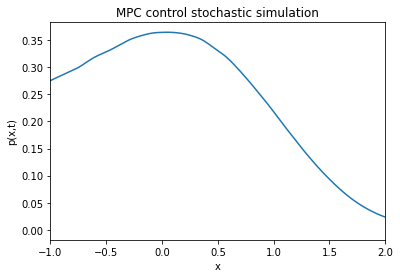

In [ ]:
plt.plot(x,pdf[:,-1].cpu().detach().numpy(),label=txt)
plt.xlim([-1, 2])
plt.title('MPC control stochastic simulation') 
plt.xlabel('x')
plt.ylabel('p(x,t)')
#plt.legend(loc="upper center")
plt.show()